# Contextual Bandits Toy Problem

This notebook demonstrates usage of the SpaceBandits package for deep contextual bandits problems.

## Toy Problem
Contextual bandits models are difficult to validate due to the nature of the problems they try to solve. The best way to confirm a model converges in practice is to use a toy problem where the reward for all possible action is known to the evaluator.<br><br>
This notebook has a very simple toy problem. We are dealing with a group of customers. We have two features: Age, and ARPU (some measure of that customer's spend at our company.) There are two groups of customers, which can be seen in the scatterplot below.<br><br>
Our company offers three promotions: the first is best for one group of customers, while the third is best for the other group. The second promotion is not optimal for either customer group. As in most real-life situations, a significant number of customers will not make purchases. Contextual bandits models handle this behavior gracefully, as they model reward generation as a stochastic process.<br><br> 
The following functions spin up our toy data.

In [1]:
import numpy as np
import pandas as pd
from random import random, randint
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

from space_bandits.toy_problem import get_cust_reward, get_customer, get_rewards
##Generate Data

## Visualizing the Groups
We can see in our simple toy problem the two groups are visually separable in the feature space.

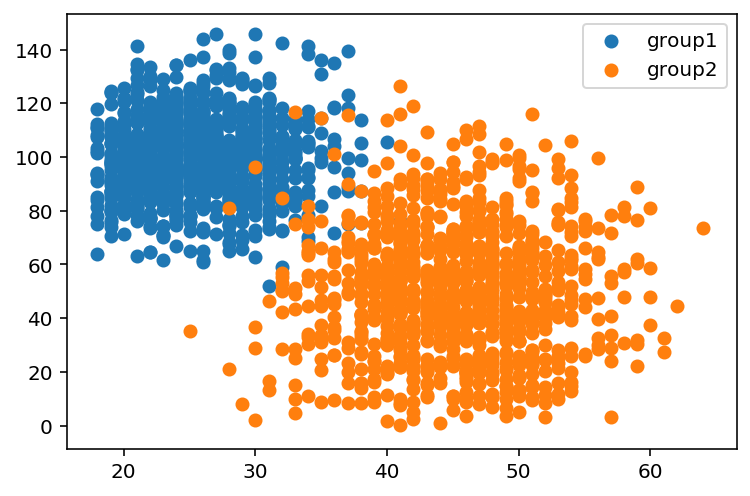

In [2]:
group1 = [get_customer(ctype=1)[1] for x in range(1000)]
group2 = [get_customer(ctype=2)[1] for x in range(1000)]
plt.scatter([x[0] for x in group1], [x[1] for x in group1], label='group1');
plt.scatter([x[0] for x in group2], [x[1] for x in group2], label='group2');
plt.legend();

## Sanity Check: Expected Rewards
To make sure the data-generating functions work well, I randomly sample from both groups of customers and get the average reward from each. This helps me confirm which offers are best for which group.

In [3]:
customers = [get_customer(ctype=1) for x in range(100000)]
rewards = np.concatenate([np.expand_dims(get_rewards(cust), axis=0) for cust in customers])
print('group 1 expected rewards: (100000 samples)', rewards.mean(axis=0))

customers = [get_customer(ctype=2) for x in range(100000)]
rewards = np.concatenate([np.expand_dims(get_rewards(cust), axis=0) for cust in customers])
rewards.mean(axis=0)
print('group 2 expected rewards: (100000 samples)', rewards.mean(axis=0))

group 1 expected rewards: (100000 samples) [9.0038 2.4685 2.027 ]
group 2 expected rewards: (100000 samples) [ 2.4943  2.505  20.192 ]


## The Model's Task
The contextual bandit model does not know that there are two customer populations. It has to discover these distributions and characterize their spending behavior simultaneously. This is the nature of the contextual bandits problem, and it's what makes the problem so hard.<br><br>
On a first pass, we'll use a Bayesian linear regression model that directly maps the features to an expected reward via linear coefficients. We'll use "online" learning for this example, meaning the model makes a decision, observes a reward, and repeats.

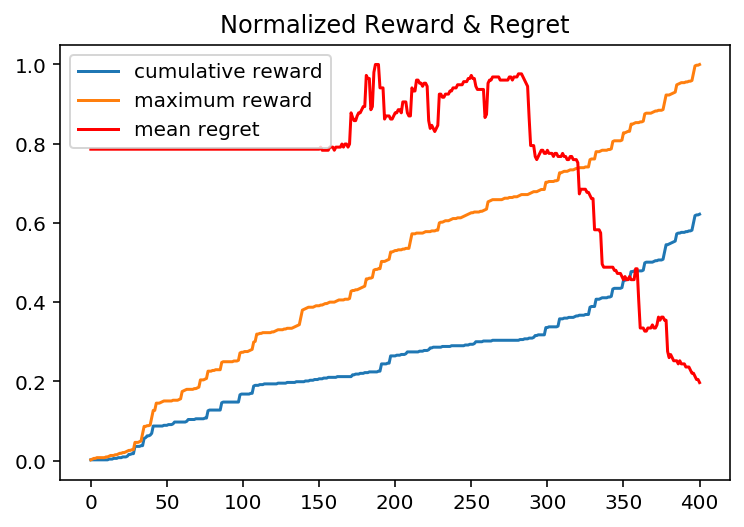

In [4]:
from space_bandits import LinearBandits

num_actions = 3
num_features = 2

linear_model = LinearBandits(num_actions, num_features, initial_pulls=100)
optimal_choices = [None, 0, 2]

def iterate_model(model, optimal_choices, steps, records=None, plot_frequency=250, avg_length=150):
    """Goes through online learning simulation with model."""
    #these will track values for plotting
    if records is None:
        records = dict()
        records['timesteps'] = []
        records['c_reward'] = []
        records['cumulative_reward'] = 0
        records['m_reward'] = []
        records['maximum_reward'] = 0
        records['regret_record'] = []
        records['avg_regret'] = []
        start = 0
    else:
        start = records['timesteps'][-1]
    for i in range(start, start+steps):
        records['timesteps'].append(i)
        #generate a customer
        cust = get_customer()
        #generate customer decisions based on group
        reward_vec = get_rewards(cust)
        #prepare features for model
        context = np.array([cust[1]])
        best_choice = optimal_choices[cust[0]]
        #get reward for 'best' choice
        mx = reward_vec[best_choice]
        records['maximum_reward'] += mx
        records['m_reward'].append(records['maximum_reward'])
        action = model.action(context)
        #get reward for the action chosen by model
        reward = reward_vec[action]
        #regret is the opportunity cost of not choosing the optimal promotion
        regret = mx - reward
        records['regret_record'].append(regret)
        records['cumulative_reward'] += reward
        records['c_reward'].append(records['cumulative_reward'])
        model.update(context, action, reward)
        #plot occasionally
        if i <= avg_length:
            if i < avg_length:
                moving_avg=0
            else:
                moving_avg = np.array(records['regret_record']).mean()
            if i == avg_length:
                records['avg_regret'] = [moving_avg] * avg_length
        else:
            moving_avg = sum(records['regret_record'][-avg_length:])/avg_length
        records['avg_regret'].append(moving_avg)
        if i % plot_frequency == 0 and i > 0:
            c_rewardplt = np.array(records['c_reward'])/max(records['m_reward'])
            m_rewardplt = np.array(records['m_reward'])/max(records['m_reward'])
            regretplt = np.array(records['avg_regret'])/max(records['avg_regret'])
            plt.plot(records['timesteps'], c_rewardplt, label='cumulative reward')
            plt.plot(records['timesteps'], m_rewardplt, label='maximum reward')
            plt.plot(records['timesteps'], regretplt, color='red', label='mean regret')
            plt.title('Normalized Reward & Regret')
            plt.legend()
            plt.show()
    return records
            
records = iterate_model(linear_model, optimal_choices, 401, plot_frequency=400)

## Optimizing
We see high regret early on, but after the model optimizes, regret (maximum reward minus earned reward) drops significantly.

## Saving/Loading
We can save and load models freely and continue learning after re-loading (as is done below). This is important functionality for an online model.

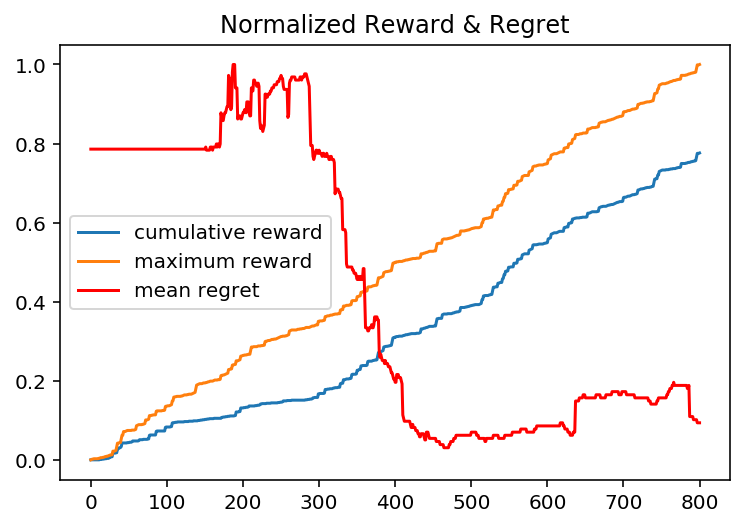

In [5]:
#test linear model saving/loading
from space_bandits import load_model
linear_model.save('test_path.pkl')
linear_model = load_model('test_path.pkl')

#continue training

records = iterate_model(linear_model, optimal_choices, 401, plot_frequency=800, records=records)

## Visualizing the Decision Boundary
After converging, the model will recommend a different offer depending on where a given customer appears in the feature space. We can visualize this as a "decision boundary."

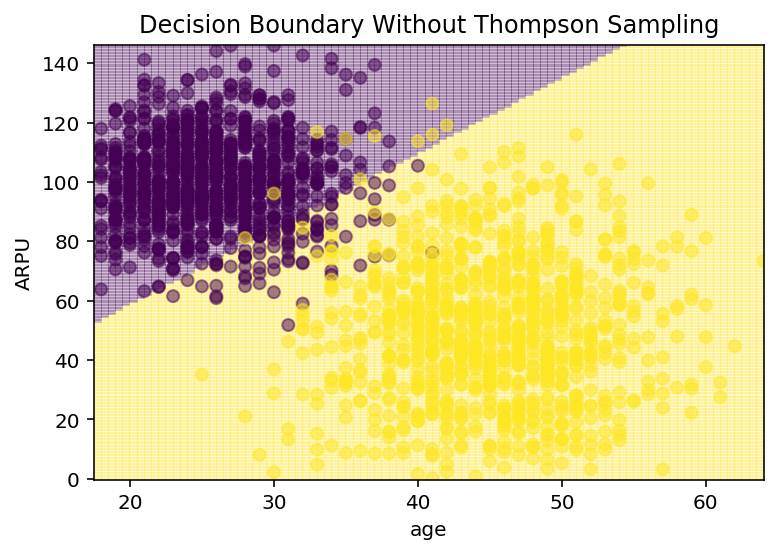

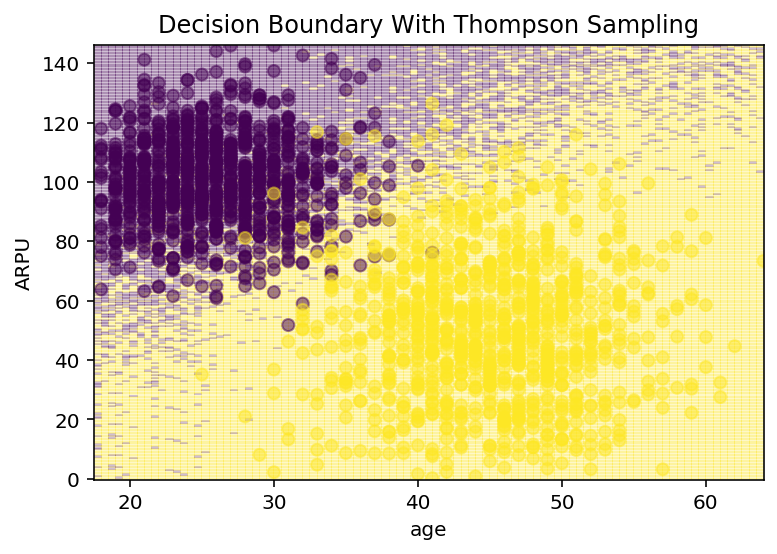

took  4.95  seconds.


In [6]:
def plot_decision_boundary(model, X, Y, h=1, scale=1., parallelize=True, title='decision boundary', thompson=False, classic=False, n_threads=-1, flip_colors=True):
    ftnames = X.columns[0], X.columns[1]
    X = X.values
    #model.fit(X[:, :2], Y)
    x_min = X[:, 1].min() - .5
    x_max = X[:, 1].max() + .5
    y_min = X[:, 0].min() - .5
    y_max = X[:, 0].max() + .5
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )
    if classic:
        Z = model.classic_predict(np.c_[xx.ravel(), yy.ravel()]/scale, thompson=thompson)
    else:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()]/scale, thompson=thompson, parallelize=parallelize)

    # Put the result into a color plot.
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, alpha=.25)

    # Add the training points to the plot.
    if flip_colors:
        Y = np.where(np.array(Y)==1, 0, 1)
    plt.scatter(X[:, 1], X[:, 0], c=Y, alpha=.5);
    #plt.scatter(X[:, 1], X[:, 0], c='black', alpha=.1);


    plt.xlabel(ftnames[1])
    plt.ylabel(ftnames[0])

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max());
    plt.title(title)
    plt.show()
    
    
from time import time
X = group1 + group2
Y = [1 for x in range(1000)] + [0 for x in range(1000)]
ages = [x[0] for x in X]
ARPUs = [x[1] for x in X]
as_df = pd.DataFrame()
as_df['ARPU'] = ARPUs
as_df['age'] = ages
X = as_df



plot_decision_boundary(linear_model, X, Y, h=.5, thompson=False, title='Decision Boundary Without Thompson Sampling')

t1 = time()
plot_decision_boundary(linear_model, X, Y, h=.5, thompson=True, parallelize=True, n_threads=3, title='Decision Boundary With Thompson Sampling')
print('took ', round(time()-t1, 2), ' seconds.')

## A Note on Thompson Sampling
As you can see above, the output of the model changes when we apply Thompson Sampling. This is how the model explores: in regions where it is uncertain (say, where the customer groups overlap), Thompson sampling returns a mix of recommendations between the two groups. This allows the model to further optimize with future examples. Thus, Thompson sampling gives us a "smart" way to explore.<br><br> While the model is confused when a customer lies just between the two groups, it can very confidently exclude the "bad" second promotion as an option. However, in regions where very few customers appear, the "bad" promotion is still recommended occasionally, as the model has no reason to think this is a bad choice where there are just too few samples to be sure.

## Neural Network
An extension of this simple model uses a neural network to build more robust features for the linear model. Let's try one such model here.<br><br>
As a default, SpaceBandits implements a single 50-node hidden layer nn model. Here, we add an additional hidden layer with 12 nodes. Using a smaller final layer reduces the computation cost of Thompson sampling. During training, the model will stop and train its neural network at a specified number of updates (default: every 50 updates.)<br><br>
### Feature Scaling
Neural Networks prefer features to have a mean of zero and a standard deviation of one, which we can get by scaling our data. By default, the NeuralBandits model will scale the data. (To turn this behavior off, pass do_scaling=False to the constructor.)

Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...


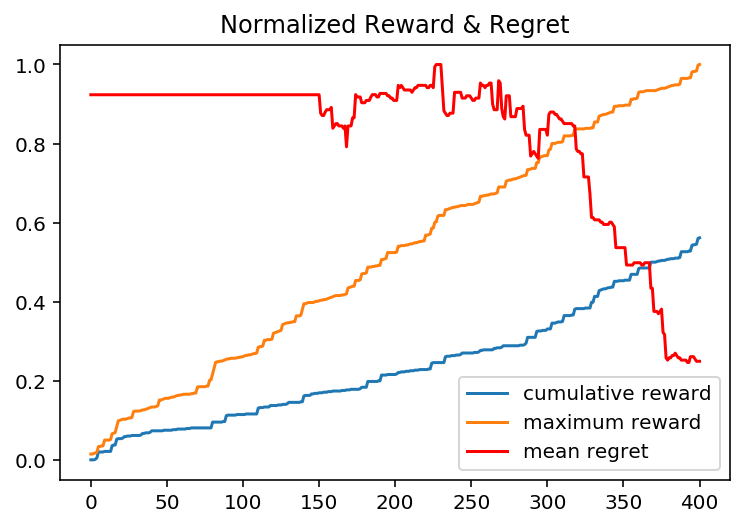

In [7]:
from space_bandits import NeuralBandits

num_actions = 3
num_features = 2
memory_size = 10000

neural_model = NeuralBandits(num_actions, num_features, initial_pulls=100, memory_size=memory_size, layer_sizes=[50, 12])
assert neural_model.data_h.memory_size == memory_size

records = iterate_model(neural_model, optimal_choices, 401, plot_frequency=400)

## Saving Neural Models
As with linear models, neural models can be saved and re-loaded during training. Now that we've migrated to torch, we can use the same load function and a simple pickle to load/save models.

In [8]:
neural_model.save('test_model')
neural_model = load_model('test_model')

Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...


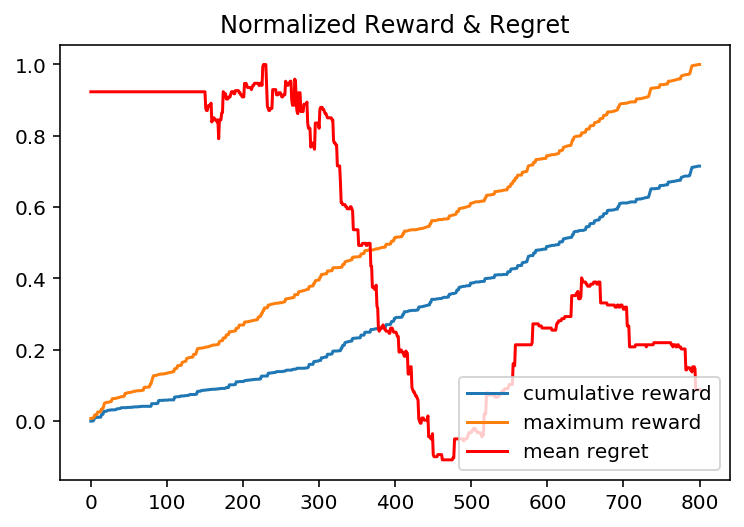

In [9]:
records = iterate_model(neural_model, optimal_choices, 401, plot_frequency=800, records=records)

The neural model performs comparably to the linear model in this case; it's valuable for situations where linear decision boundaries are not effective.

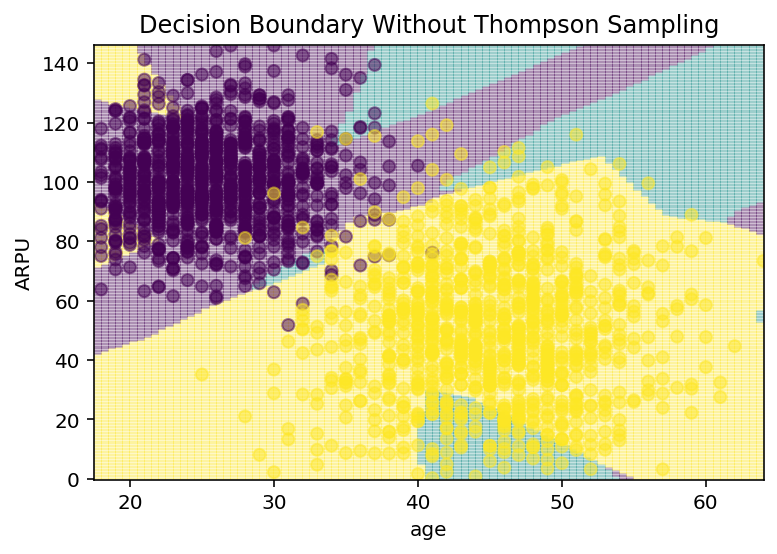

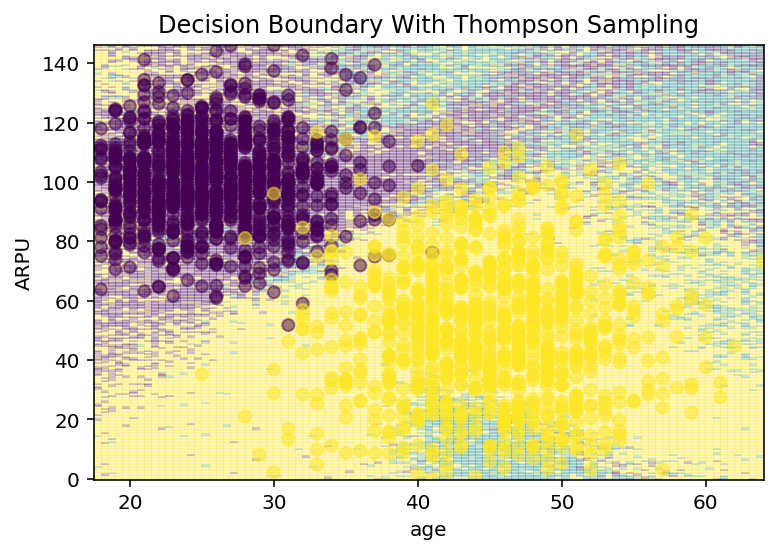

took  6.916409492492676


In [10]:
plot_decision_boundary(neural_model, X, Y, h=.5, thompson=False, title='Decision Boundary Without Thompson Sampling', n_threads=3)


t1 = time()
plot_decision_boundary(neural_model, X, Y, h=.5, thompson=True, parallelize=True, title='Decision Boundary With Thompson Sampling', n_threads=3)
print('took ', time() - t1)

## Training from Historic Data
Online learning is great, but in practice we can't always see rewards immediately. SpaceBandits provides methods for rapidly training from historic data as well.<br><br>
These methods play nice with online methods; batch training with new calls to .fit will retain information from previous calls to .fit.

In [11]:
from space_bandits.toy_problem import generate_dataframe

df = generate_dataframe(2000)

df.head()

age        ARPU  action  reward
0  45.0   16.685616       0       0
1  43.0   53.275743       0       0
2  47.0   88.883321       0       0
3  31.0  106.645048       1       0
4  21.0  109.143031       2       0

## Preparing Data for Training
As can be seen above, rows of data must be organized into tripets: features, actions, and rewards. In this case, these records represent a customer (age, ARPU), action (which promotion they saw), and what reward was earned (how much money the customer spent on the promotion.)

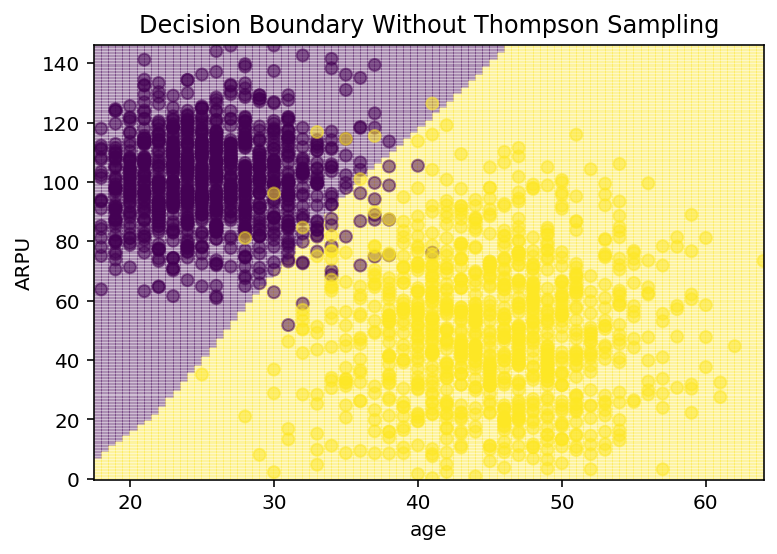

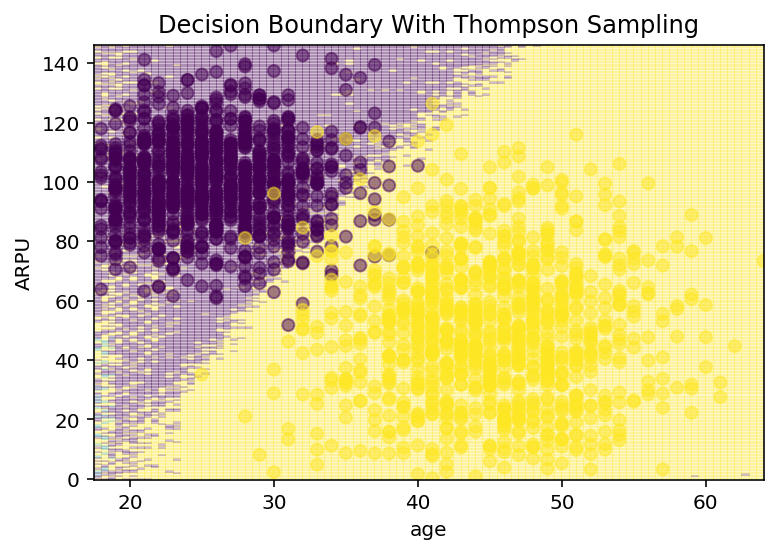

In [12]:
#split data into triplets
contexts = df[['age', 'ARPU']]
actions = df['action']
rewards = df['reward']

#initialize new neural model
new_model = NeuralBandits(3, 2, layer_sizes=[50, 12], verbose=False)
#call .fit method; num_updates will repeat training n times
new_model.fit(contexts, actions, rewards)

plot_decision_boundary(new_model, X, Y, h=.5, thompson=False, scale=1., title='Decision Boundary Without Thompson Sampling')
plot_decision_boundary(new_model, X, Y, h=.5, thompson=True, scale=1., title='Decision Boundary With Thompson Sampling', n_threads=3)

We see here that the model learns a reasonable decision boundary; Thompson sampling reveals it is still eager to explore, but it will generally recommend well for customers in well-explored locations in the feature space.

## Biased Data
The above training data had random promotion assignments. Let's say our training data came from a previous campaign, where the marketing department sent promotion based on the following rules:<br>
1. Customers in the range 0-50 ARPU recieve promotion 1. 
2. Customers in the range 51-100 ARPU recieve promotion 2.
3. Customers with greater than 100 ARPU recieve promotion 3.

This introduces bias into our training data. Let's see what effect this has on our neural model optimization.

In [13]:
from space_bandits.toy_problem import generate_biased_dataframe

df = generate_biased_dataframe(2000)

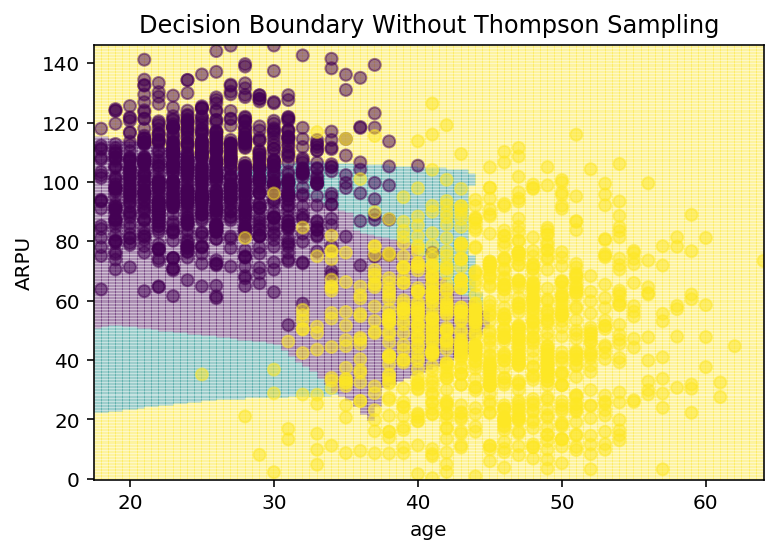

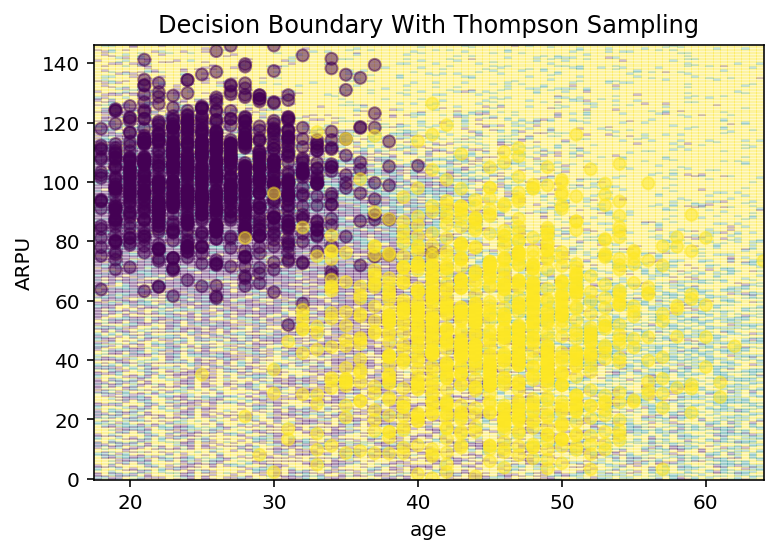

In [14]:
contexts = df[['age', 'ARPU']]
actions = df['action']
rewards = df['reward']

bias_model = NeuralBandits(3, 2, layer_sizes=[50, 12], verbose=False)
bias_model.fit(contexts, actions, rewards)

plot_decision_boundary(bias_model, X, Y, h=.5, thompson=False, scale=1., title='Decision Boundary Without Thompson Sampling')
plot_decision_boundary(bias_model, X, Y, h=.5, thompson=True, scale=1., title='Decision Boundary With Thompson Sampling', n_threads=3)

We see that the net effect of using biased data is model uncertainty; Thompson sampling gives us exploratory behavior even after training on 2000 examples. There do appear to be certain regions in the feature space that have converged to optimal solutions.

## Nonlinear Problem
The previous example can be solved with a simple linear decision boundary. Let's try a more complicated example.

In [16]:
import numpy as np
import pandas as pd
from random import random
import matplotlib.pyplot as plt

from space_bandits.toy_problem import get_customer_nl, get_rewards_nl, get_cust_reward_nl

get_customer = get_customer_nl
get_rewards = get_rewards_nl
get_cust_reward = get_cust_reward_nl
##Generate Data

In [17]:
customers = [get_customer(ctype=0) for x in range(100000)]
rewards = np.concatenate([np.expand_dims(get_rewards(cust), axis=0) for cust in customers])
print('group 1 expected rewards: (10000 samples)', rewards.mean(axis=0))

customers = [get_customer(ctype=1) for x in range(100000)]
rewards = np.concatenate([np.expand_dims(get_rewards(cust), axis=0) for cust in customers])
print('group 1 expected rewards: (10000 samples)', rewards.mean(axis=0))

customers = [get_customer(ctype=2) for x in range(100000)]
rewards = np.concatenate([np.expand_dims(get_rewards(cust), axis=0) for cust in customers])
rewards.mean(axis=0)
print('group 2 expected rewards: (10000 samples)', rewards.mean(axis=0))

optimal_choices = [0, 1, 2]
#confirm expected rewards

group 1 expected rewards: (10000 samples) [9.0078 2.487  1.013 ]
group 1 expected rewards: (10000 samples) [ 1.0006  12.55625  5.044  ]
group 2 expected rewards: (10000 samples) [ 0.9916  1.256  25.042 ]


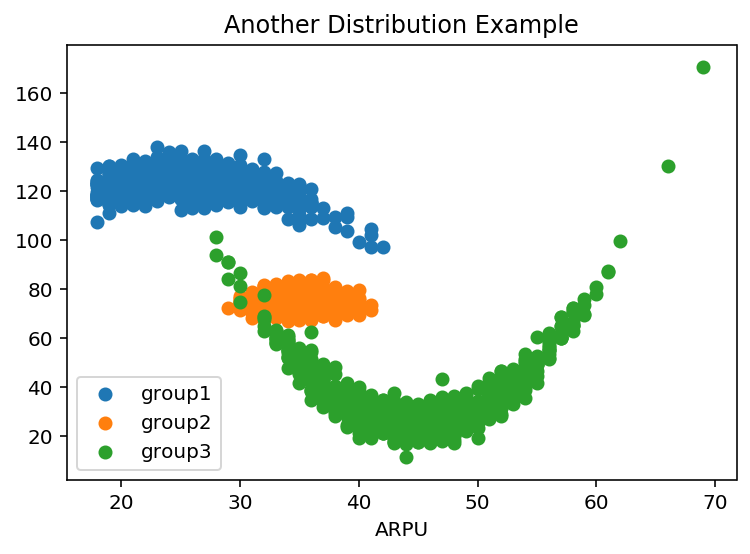

In [18]:
group1 = []
group2 = []
group3 = []
for i in range(1000):
    group1.append(get_customer(0))
    group2.append(get_customer(1))
    group3.append(get_customer(2))
    
plt.scatter([x[1][0] for x in group1], [x[1][1] for x in group1], label='group1')
plt.scatter([x[1][0] for x in group2], [x[1][1] for x in group2], label='group2')
plt.scatter([x[1][0] for x in group3], [x[1][1] for x in group3], label='group3')
plt.xlabel('age')
plt.xlabel('ARPU')
plt.title('Another Distribution Example')
plt.legend();

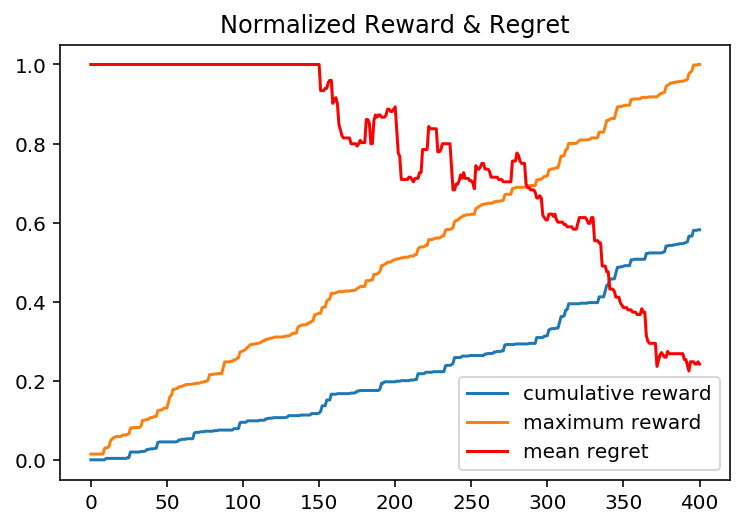

In [19]:
num_actions = 3
num_features = 2

linear_model = LinearBandits(num_actions, num_features, initial_pulls=100)

records = iterate_model(linear_model, optimal_choices, 401, plot_frequency=400)

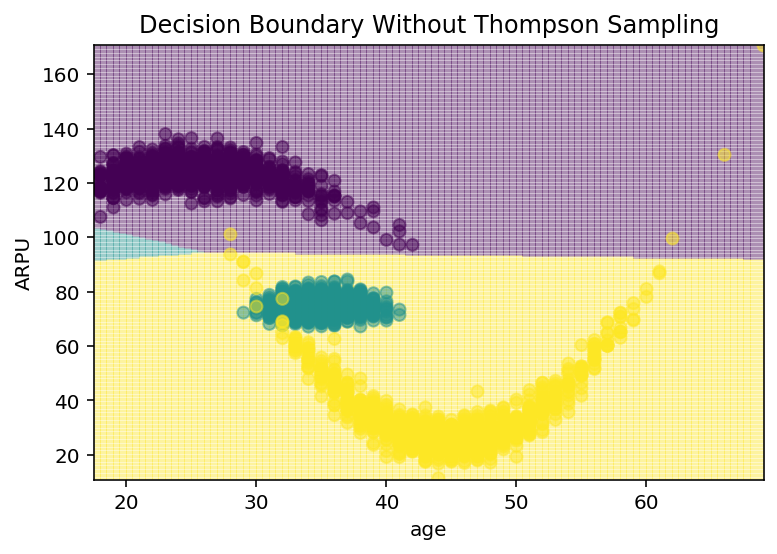

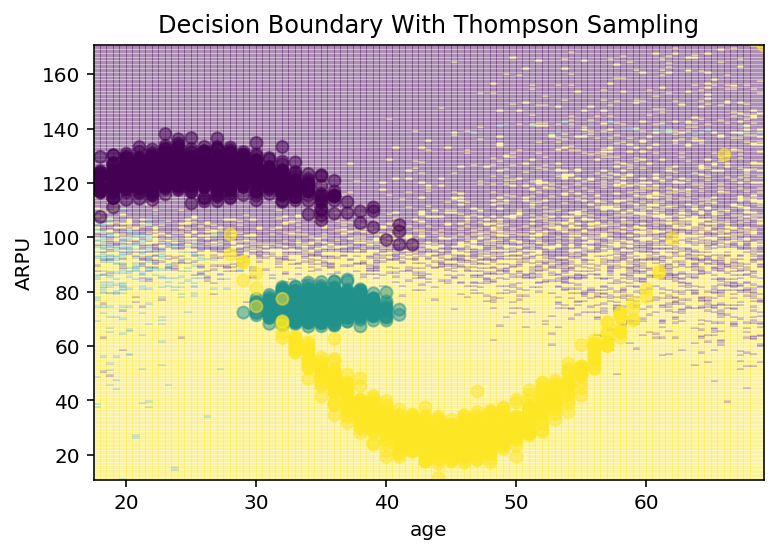

In [20]:
X = group1 + group2 + group3
X = [x[1] for x in X]
Y = [0 for x in range(1000)] + [1 for x in range(1000)] + [2 for x in range(1000)]
ages = [x[0] for x in X]
ARPUs = [x[1] for x in X]
as_df = pd.DataFrame()
as_df['ARPU'] = ARPUs
as_df['age'] = ages
X = as_df

plot_decision_boundary(linear_model, X, Y, h=.5, thompson=False, scale=1., title='Decision Boundary Without Thompson Sampling', flip_colors=False)
plot_decision_boundary(linear_model, X, Y, h=.5, thompson=True, scale=1., title='Decision Boundary With Thompson Sampling', flip_colors=False)

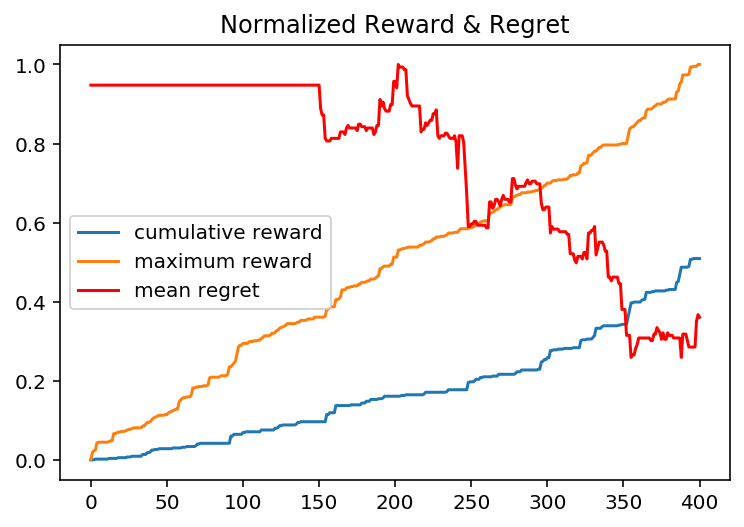

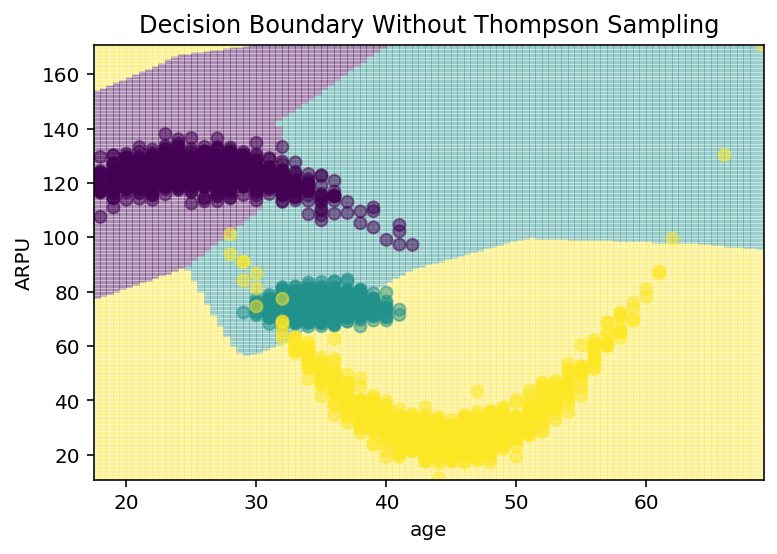

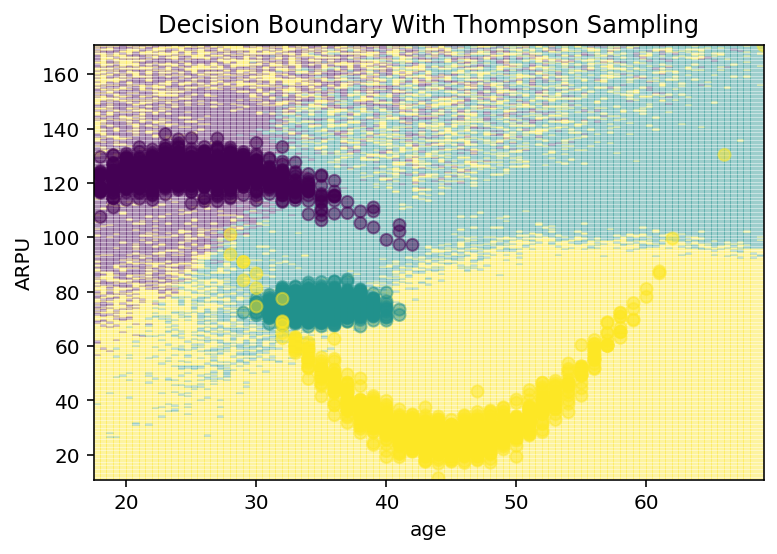

In [21]:
neural_model = NeuralBandits(num_actions, num_features, layer_sizes=[50,12], initial_pulls=100, verbose=False, initial_lr=.01)
records = iterate_model(neural_model, optimal_choices, 401, plot_frequency=400)

plot_decision_boundary(neural_model, X, Y, h=.5, thompson=False, scale=1., title='Decision Boundary Without Thompson Sampling', flip_colors=False)
plot_decision_boundary(neural_model, X, Y, h=.5, thompson=True, scale=1., title='Decision Boundary With Thompson Sampling', flip_colors=False)

As expected, the neural model is more capable of learning nonlinear decision boundaries than the linear model.